In [3]:
import numpy as np
import pandas as pd
import os
import pickle
from local.scoring import score

In [4]:
rootdir='results_tuned/tune_train_config_lr1e-4_wd1e-5/'
test_scorefil="val_scores.txt"
audio_categories = ['breathing-deep', 
                    'breathing-shallow', 
                    'cough-heavy', 
                    'cough-shallow', 
                    'vowel-a', 
                    'vowel-e', 
                    'vowel-o', 
                    'counting-normal', 
                    'counting-fast',
                   'symptoms'
                   ]

for idx, audio_category in enumerate(audio_categories):
    #print(audio_category)
    #scores=open(os.path.join(rootdir,audiocategory,'train_scores.txt')).readlines()
    df=pd.read_csv(os.path.join(rootdir, audio_category, test_scorefil), sep=" ", header=None)
    keylist=list(df[0])
    #print(len(keylist))
    if idx==0:
        temp=list(set(keylist))
    else:
        temp=list(set(temp) & set(keylist))
    #print(len(temp))
    
common_ids=temp  
print(common_ids[:3])
print(len(common_ids))

['dDvHec65MWh2REqq5mABZJvmlXI3', '8XF2UFLn3Wd6dHHMdOlcGbQiMqb2', 'sZXioPNq72VC9DKY05wQtL6MB452']
240


In [5]:
def scoring_v2(reference_labels, sys_scores,specificities_chosen=[0.5,0.95]):

    thresholds=np.arange(0,1,0.0001)

    AUC, TPR, TNR = score(reference_labels,sys_scores,thresholds=thresholds)

    specificities=[]
    sensitivities=[]

    decision_thresholds = []
    for specificity_threshold in specificities_chosen:
        ind = np.where(TNR>specificity_threshold)[0]
        sensitivities.append( TPR[ind[0]])
        specificities.append( TNR[ind[0]])
        decision_thresholds.append( thresholds[ind[0]])

    # pack the performance metrics in a dictionary to save & return
    # Each performance metric (except AUC) is a array for different threshold values
    # Specificity at 90% sensitivity
    scores={'TPR':TPR,
            'FPR':1-TNR,
            'AUC':AUC,
            'sensitivity':sensitivities,
            'specificity':specificities,
            'operatingPts':decision_thresholds,
			'thresholds':thresholds}

    return AUC,sensitivities[0],specificities[0],sensitivities[1],specificities[1], decision_thresholds[1]

In [5]:
# test_ids=[]

# temp_lines=open(os.path.join(rootdir,'breathing-deep',test_scores),'r').readlines()

# for line in temp_lines:
#     key, val=line.strip().split(" ")
#     if key in common_ids:
#         test_ids.append(key)
# print(test_ids[:3])
# print("len of test ids:", len(test_ids))

In [6]:
test_lines=open('data/val','r').readlines()
#test_lines.sort()
test_labels_dict={}
test_labels=[]
for line in test_lines:
    key, val = line.strip().split(" ")
    if val=='p':
        val=1
    elif val=='n':
        val=0
    else:
        raise ValueError(" Not a valid label.")
    if key in common_ids:
        test_labels_dict[key]=val
test_labels=[float(test_labels_dict[id]) for id in common_ids]
print(test_labels[-10:])
print(len(test_labels))

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
240


In [7]:
for idx, audio_category in enumerate(audio_categories):
    dict={}
    test_scores=[]
    test_score_lines=open(os.path.join(rootdir,audio_category,test_scorefil),'r').readlines()
    #test_score_lines.sort()
    
    for line in test_score_lines:
        key, val=line.strip().split(" ")
        if key in common_ids:
            dict[key]=val
    assert sorted(list(dict.keys()))==sorted(common_ids)
        #test_scores.append(float(val))

    test_scores=[float(dict[key]) for key in common_ids]
   
    test_scores=np.array(test_scores)
    
    test_scores=test_scores.reshape(-1,1)
    auc, _,_,sens,spec,_=scoring_v2(list(test_labels), list(test_scores))
    print("{}--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f}".format(audio_category, auc, sens, spec))
    #print(scores)
    #print(scores)
    
    if idx==0:
        test_score_arr=test_scores
        #print(score_arr)
    else:
        test_score_arr=np.concatenate((test_score_arr, test_scores), axis=1)
    #print(score_arr)
    #print(len(scores))
    #print(test_score_arr.shape)
    #break
print(test_score_arr.shape)
print(test_score_arr)



breathing-deep--AUC: 0.7706, Sens: 0.2787, Spec: 0.9553
breathing-shallow--AUC: 0.7450, Sens: 0.2459, Spec: 0.9553
cough-heavy--AUC: 0.7161, Sens: 0.3607, Spec: 0.9553
cough-shallow--AUC: 0.7223, Sens: 0.2951, Spec: 0.9553
vowel-a--AUC: 0.7083, Sens: 0.2951, Spec: 0.9553
vowel-e--AUC: 0.7330, Sens: 0.2459, Spec: 0.9553
vowel-o--AUC: 0.7429, Sens: 0.2623, Spec: 0.9553
counting-normal--AUC: 0.7649, Sens: 0.2459, Spec: 0.9553
counting-fast--AUC: 0.8162, Sens: 0.4262, Spec: 0.9553
symptoms--AUC: 0.8598, Sens: 0.7213, Spec: 0.9553
(240, 10)
[[0.32733469 0.31407    0.03357014 ... 0.2001936  0.32882324 0.79800222]
 [0.19132561 0.79621905 0.04571254 ... 0.21747175 0.06658892 0.19674129]
 [0.06252027 0.05014184 0.02619184 ... 0.01185008 0.11298728 0.79800222]
 ...
 [0.51837173 0.31730556 0.93216693 ... 0.51731206 0.79172314 0.91943734]
 [0.06389389 0.00206153 0.19133373 ... 0.19066882 0.03567969 0.98797664]
 [0.06012309 0.21656186 0.22204526 ... 0.62280941 0.45860873 0.19674129]]


In [8]:
# Baseline score
from local.scoring import score
baseline_test_score=np.mean(test_score_arr, axis=1)
auc,_,_,sens,spec,thres=scoring_v2(list(test_labels), list(baseline_test_score))
print("fusion--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at thres:{:.4f}".format(auc, sens, spec,thres))



fusion--AUC: 0.8704, Sens: 0.4754, Spec: 0.9553 at thres:0.4267


max weight: [[0.1108685 ]
 [0.01770559]
 [0.13726011]
 [0.00308136]
 [0.03825548]
 [0.00544842]
 [0.02939652]
 [0.02556089]
 [0.15294135]
 [0.47948178]]


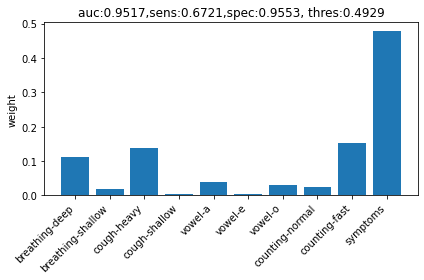



max weight: [[0.01779913]
 [0.19542441]
 [0.04799397]
 [0.04135268]
 [0.0538871 ]
 [0.00055528]
 [0.06843693]
 [0.05313932]
 [0.11051242]
 [0.41089875]]


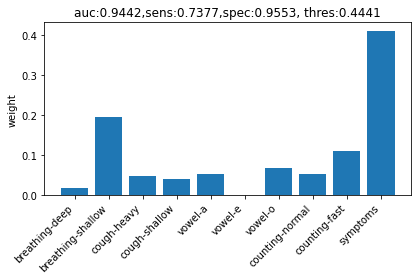



max weight: [[0.00462131]
 [0.00950714]
 [0.13710733]
 [0.04757999]
 [0.13080908]
 [0.0306498 ]
 [0.01287369]
 [0.00129713]
 [0.22183594]
 [0.40371859]]


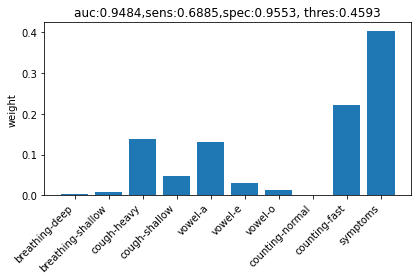



max weight: [[0.00294725]
 [0.08098264]
 [0.02573944]
 [0.22270233]
 [0.09573208]
 [0.09829164]
 [0.0176236 ]
 [0.04116807]
 [0.06553039]
 [0.34928256]]


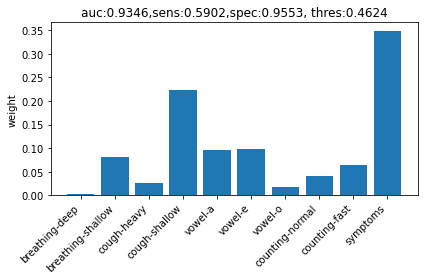



max weight: [[0.0588364 ]
 [0.02060387]
 [0.01246888]
 [0.00692376]
 [0.08527943]
 [0.00146273]
 [0.08777528]
 [0.16076059]
 [0.09044143]
 [0.47544763]]


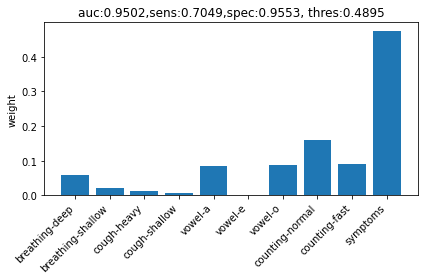

In [12]:
import matplotlib.pyplot as plt 
import pickle

best_weights=[]

for iter in range(5):
    tst_aucs = []
    tst_sens=[]
    tst_specs=[]
    weights = []
    thresholds= []

    for i in range(100):
        alphas=np.ones(len(audio_categories),np.float32)
        s = np.random.dirichlet(alphas,1)
        s = s.reshape(-1,1)
        w_score = np.matmul(test_score_arr, s)
        #print(w_score.shape)
        #auc = score(list(test_labels), list(w_score))[0]
        auc, _, _, sens,spec,threshold = scoring_v2(list(test_labels), list(w_score))
        tst_aucs.append(auc)
        tst_sens.append(sens)
        tst_specs.append(spec)
        weights.append(s)
        thresholds.append(threshold)


        #print(s)
    max_idx = np.array(tst_aucs).argmax()
    max_weight = np.array(weights[max_idx])
    best_weights.append(max_weight)
    print("max weight: {}".format(max_weight))
    max_auc=tst_aucs[max_idx]
    max_sens=tst_sens[max_idx]
    max_spec=tst_specs[max_idx]
    max_threshold=thresholds[max_idx]

    category_dict={}
    for idx, audio_category in enumerate(audio_categories):
        category_dict[audio_category]=max_weight[idx].item()

    #print("max_auc: {}".format(max_auc)) 
    #print("with weights:\n {}".format(category_dict))
    #plt.plot(tst_aucs)
    #plt.show()

    fig = plt.figure()
    plt.bar(range(len(category_dict)), list(category_dict.values()))
    plt.xticks(range(len(category_dict)), list(category_dict.keys()), rotation=45,horizontalalignment='right')
    plt.title('auc:{:.4f},sens:{:.4f},spec:{:.4f}, thres:{:.4f}'.format(max_auc,max_sens,max_spec, max_threshold))
    
    dir='{}/fusion_combs/val_data/'.format(rootdir)
    if not os.path.exists(dir):
        os.makedirs(dir)
    plt.ylabel('weight')
    plt.tight_layout()
    plt.savefig(dir + '/c{}.png'.format(iter))
    plt.show()

    plt.close()
    print("\n")

with open('{}/fusion_combs/val_data/best_weights.pkl'.format(rootdir),'wb') as f:
   pickle.dump(best_weights, f,protocol=pickle.HIGHEST_PROTOCOL)


### **New test data**

In [18]:

new_test_dir='data'
new_test_scorefil='test2_scores.txt'
for idx, audio_category in enumerate(audio_categories):
    #print(audio_category)
    #scores=open(os.path.join(rootdir,audiocategory,'train_scores.txt')).readlines()
    df=pd.read_csv(os.path.join(rootdir, audio_category,new_test_scorefil ), sep=" ", header=None)
    keylist=list(df[0])
    #print(len(keylist))
    if idx==0:
        temp=list(set(keylist))
    else:
        temp=list(set(temp) & set(keylist))
    #print(len(temp))
    
new_common_ids=temp  
print(new_common_ids[:3])
print(len(new_common_ids))

['dZvjWWbzA8ZHagEibhMy4sJdd1n2', 'VvbSXSJduhNoeJsgDEYbLaldzdR2', '4KISxr5Elsd5AtONZ380AtOuGbb2']
200


In [11]:
# test_ids=[]

# temp_lines=open(os.path.join('results','breathing-deep','new_test_scores.txt'),'r').readlines()

# for line in temp_lines:
#     key, val=line.strip().split(" ")
#     if key in new_common_ids:
#         test_ids.append(key)
# print(test_ids[:3])
# print("len of test ids:", len(test_ids))

In [22]:
new_test_lines=open('{}/test2'.format(new_test_dir),'r').readlines()
#test_lines.sort()
new_test_labels_dict={}
new_test_labels=[]

for line in new_test_lines:
    key, val = line.strip().split(" ")
    if val=='p':
        val=1
    elif val=='n':
        val=0
    else:
        raise ValueError(" Not a valid label.")
    if key in new_common_ids:
        new_test_labels_dict[key]=val
        
new_test_labels=[float(new_test_labels_dict[id]) for id in new_common_ids]
print(new_test_labels[-10:])
print(len(new_test_labels))

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
200


In [23]:
for idx, audio_category in enumerate(audio_categories):
    new_dict={}
    new_test_scores=[]
    new_test_score_lines=open(os.path.join(rootdir, audio_category, new_test_scorefil),'r').readlines()
    #test_score_lines.sort()
    
    for line in new_test_score_lines:
        key, val=line.strip().split(" ")
        if key in new_common_ids:
            new_dict[key]=val
    assert sorted(list(new_dict.keys()))==sorted(new_common_ids)
        #test_scores.append(float(val))

    new_test_scores=[float(new_dict[key]) for key in new_common_ids]
   
    new_test_scores=np.array(new_test_scores)
    
    new_test_scores=new_test_scores.reshape(-1,1)

    auc, _,_,sens,spec,_=scoring_v2(list(new_test_labels), list(new_test_scores))
    print("{}--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f}".format(audio_category, auc, sens, spec))

    if idx==0:
        new_test_score_arr=new_test_scores
        #print(score_arr)
    else:
        new_test_score_arr=np.concatenate((new_test_score_arr, new_test_scores), axis=1)
    #print(score_arr)
    #print(len(scores))
    #print(test_score_arr.shape)
    #break
print(new_test_score_arr.shape)
print(new_test_score_arr)

breathing-deep--AUC: 0.7954, Sens: 0.3600, Spec: 0.9533
breathing-shallow--AUC: 0.8345, Sens: 0.2800, Spec: 0.9533
cough-heavy--AUC: 0.8107, Sens: 0.2200, Spec: 0.9533
cough-shallow--AUC: 0.7915, Sens: 0.2800, Spec: 0.9533
vowel-a--AUC: 0.7914, Sens: 0.3600, Spec: 0.9533
vowel-e--AUC: 0.7846, Sens: 0.3400, Spec: 0.9533
vowel-o--AUC: 0.7774, Sens: 0.2600, Spec: 0.9533
counting-normal--AUC: 0.8315, Sens: 0.4200, Spec: 0.9533
counting-fast--AUC: 0.8391, Sens: 0.4200, Spec: 0.9533
symptoms--AUC: 0.8881, Sens: 0.3600, Spec: 0.9600
(200, 10)
[[0.14639716 0.26531562 0.09342427 ... 0.29047933 0.44145132 0.19674129]
 [0.40667854 0.25446009 0.70424599 ... 0.24201713 0.13190469 1.        ]
 [0.27527809 0.48684425 0.20736158 ... 0.37082232 0.61588445 0.98797664]
 ...
 [0.81756447 0.88189725 0.94711756 ... 0.93177655 0.71628974 0.98797664]
 [0.00618863 0.02463999 0.01220168 ... 0.01815852 0.02638985 0.19674129]
 [0.00194356 0.18430683 0.17395432 ... 0.09769474 0.0108908  0.19674129]]


In [24]:
from local.scoring import score
new_baseline_test_score=np.mean(new_test_score_arr, axis=1)
auc, _,_,sens,spec,thres=scoring_v2(list(new_test_labels), list(new_baseline_test_score))
#scoring_v2(list(test_labels), list(test_score_arr[:,9]))
print("fusion--AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at thres:{:.4f}".format(auc, sens, spec,thres))

fusion--AUC: 0.8968, Sens: 0.5800, Spec: 0.9533 at thres:0.5475


In [15]:
s = np.array(best_weights[0]).reshape(-1,1)
s.shape

(10, 1)

In [25]:
for i in range(5):
    s = np.array(best_weights[i]).reshape(-1,1)
    #s = np.array([0,0,0,0,0,0,0,0,0,1]).reshape(-1,1)
    w_score = np.matmul(new_test_score_arr, s)
    auc, _, _, sens,spec, thres = scoring_v2(list(new_test_labels), list(w_score))
    print("AUC: {:.4f}, Sens: {:.4f}, Spec: {:.4f} at threshold: {:.4f}".format(auc, sens, spec, thres))

AUC: 0.9327, Sens: 0.5000, Spec: 0.9533 at threshold: 0.6824
AUC: 0.9337, Sens: 0.5600, Spec: 0.9533 at threshold: 0.6588
AUC: 0.9296, Sens: 0.5000, Spec: 0.9533 at threshold: 0.6659
AUC: 0.9253, Sens: 0.5800, Spec: 0.9533 at threshold: 0.6220
AUC: 0.9307, Sens: 0.5800, Spec: 0.9533 at threshold: 0.6635


In [17]:
np.array(best_weights).shape

(5, 10, 1)

In [9]:
# import scipy.io as sio 
# #sio.savemat('results/fusion_combs/test_data/best_weights_arr.mat',mdict={'data':np.array(best_weights)})
# sio.loadmat('results/fusion_combs/test_data/best_weights_arr.mat')['data']

In [ ]:
"""
avg_top_weight=np.ones(len(audio_categories),np.float32)


for iter in range(5):
    tst_aucs = []
    tst_sens=[]
    tst_specs=[]
    weights = []
    alphas=avg_top_weight.ravel()
    print("alphas: {}".format(alphas))
    if sum(alphas>0) != len(alphas):print("alpha becomes zero; aborting.."); break

    for i in range(1000):

        #valid_catgs = test_score_arr[(alphas>0)]
        #alphas=alphas[alphas>0]

        s = np.random.dirichlet(alphas,1)
        s = s.reshape(-1,1)
        
        #print(s.shape)
        w_score = np.matmul(test_score_arr, s)
        #w_score = np.matmul(valid_catgs, s)
        #print(w_score.shape)
        auc, _, _, sens,spec = scoring_v2(list(test_labels), list(w_score))
        tst_aucs.append(auc)
        tst_sens.append(sens)
        tst_specs.append(spec)
        weights.append(s)


    
    # MAX VALUES
    max_idx=np.array(tst_aucs).argmax()
    max_weight = np.array(weights[max_idx])
    print("max weight: {}".format(max_weight))
    max_auc=tst_aucs[max_idx]
    max_sens=tst_sens[max_idx]
    max_spec=tst_specs[max_idx]

    # TOP VALUES
    top_idxs = np.array(tst_aucs).argsort()[-10:]
    #print(max_idxs)

    top_weights = np.array(weights)[top_idxs]
    avg_top_weight=np.mean(top_weights,axis=0)
    #print(avg_top_weight)

    top_aucs=np.array(tst_aucs)[top_idxs]



    #break

    category_dict={}
    #valid_categories=np.array(audio_categories)[alphas>0]
    #for idx, audio_category in enumerate(valid_categories):
    for idx, audio_category in enumerate(audio_categories):
        category_dict[audio_category]=max_weight[idx].item()

    fig = plt.figure()
    plt.bar(range(len(category_dict)), list(category_dict.values()))
    plt.xticks(range(len(category_dict)), list(category_dict.keys()), rotation=45,horizontalalignment='right')
    plt.title('auc:{:.4f},sens:{:.4f},spec:{:.4f}'.format(max_auc,max_sens,max_spec))
    
    dir='fusion_combs/MLP2LAYER/new_test_data/iterative/'
    if not os.path.exists(dir):
        os.makedirs(dir)
    plt.ylabel('weight')
    plt.tight_layout()
    plt.savefig(dir + '/c{}.png'.format(iter))
    
    plt.show()

    plt.close()
    print("\n") 
"""      

'\navg_top_weight=np.ones(len(audio_categories),np.float32)\n\n\nfor iter in range(5):\n    tst_aucs = []\n    tst_sens=[]\n    tst_specs=[]\n    weights = []\n    alphas=avg_top_weight.ravel()\n    print("alphas: {}".format(alphas))\n    if sum(alphas>0) != len(alphas):print("alpha becomes zero; aborting.."); break\n\n    for i in range(1000):\n\n        #valid_catgs = test_score_arr[(alphas>0)]\n        #alphas=alphas[alphas>0]\n\n        s = np.random.dirichlet(alphas,1)\n        s = s.reshape(-1,1)\n        \n        #print(s.shape)\n        w_score = np.matmul(test_score_arr, s)\n        #w_score = np.matmul(valid_catgs, s)\n        #print(w_score.shape)\n        auc, _, _, sens,spec = scoring_v2(list(test_labels), list(w_score))\n        tst_aucs.append(auc)\n        tst_sens.append(sens)\n        tst_specs.append(spec)\n        weights.append(s)\n\n\n    \n    # MAX VALUES\n    max_idx=np.array(tst_aucs).argmax()\n    max_weight = np.array(weights[max_idx])\n    print("max weigh